# Asking Follow-Up Clarifications to Resolve Ambiguities in Human-Robot Conversation

Welcome to the demo notebook for "Asking Follow-Up Clarifications to Resolve Ambiguities in Human-Robot Conversation"

In this notebook, we show-case how to:
* find described scene regions
* generate follow-up clarification questions.

# DETR Object Detection Module

In [1]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);


import sys
from PIL import Image
import json
import requests
from base64 import b64encode
import json

In [2]:
# COCO classes
CLASSES1 = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS1 = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [3]:
# standard PyTorch mean-std input image normalization
transform1 = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy1(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes1(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy1(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [4]:
def plot_results1(ifsave, pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS1 * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=8))
        cl = p.argmax()
        text = f'{CLASSES1[cl]}'
        ax.text(xmin, ymin, text, fontsize=48,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    #plt.show()
    if ifsave:
        #plt.show()
        plt.savefig(TAR_DIR+'detection.jpg',bbox_inches='tight')
    plt.close()

In [5]:
def obj_det(ifsave, im):
    # mean-std normalize the input image (batch-size: 1)
    img = transform1(im).unsqueeze(0)

    # propagate through the model
    outputs = model_det(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes1(outputs['pred_boxes'][0, keep], im.size)

    plot_results1(ifsave, im, probas[keep], bboxes_scaled)
    return (probas[keep], bboxes_scaled)

In [6]:
model_det = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model_det.eval();

Using cache found in /home/irmak/.cache/torch/hub/facebookresearch_detr_master


# Referring Expression Generation Component


In [7]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from PIL import Image

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from math import atan2,degrees


from object_detection.utils import label_map_util


import cv2
import sys

import time

import copy

# This is needed to display the images.
%matplotlib inline

In [8]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [9]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [10]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [11]:
def findTargetobj(posX,posY,output_dict,name):
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    object_pos = []
    for pos in output_dict['detection_boxes']:
        object_pos = object_pos + [(pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height)]
    target = 0
    for pos in object_pos:
        #print(category_index[output_dict['detection_classes'][target]]['name'], pos[0], pos[1], pos[2], pos[3])
        if pos[0] < posX and pos[1] > posX and pos[2] < posY and pos[3] > posY and category_index[output_dict['detection_classes'][target]]['name']==name:
            break
        target += 1
    if target == len(object_pos):
        target = -1
    return target

In [12]:
def objectDetection(output_dict):
    object_pos = []
    norm_pos = []
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    for i in range(len(output_dict['detection_scores'])):
            if output_dict['detection_classes'][i] in category_index.keys() and output_dict['detection_scores'][i]>0.30:
                class_name = category_index[output_dict['detection_classes'][i]]['name']
                pos = output_dict['detection_boxes'][i]
                object_pos = object_pos + [(pos[1]*im_width, pos[0]*im_height, pos[3]*im_width-pos[1]*im_width,  pos[2]*im_height-pos[0]*im_height)]
                norm_pos = norm_pos + [(pos[1], pos[0], pos[3]-pos[1],  pos[2]-pos[0])]
    return norm_pos,object_pos

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import KFold
import numpy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras
from tensorflow.keras.models import load_model

def rel_return(posX,posY,name,output_dict, model):
    norm_pos,object_pos = objectDetection(output_dict)
    target = findTargetobj(posX,posY,output_dict,name)

    condidate_rel= []
    condidate_rel_strong =[]
    for i in range(len(object_pos)):
        if i != target:
            tem_d = np.asarray([norm_pos[target] + norm_pos[i]])
            pred = model.predict(tem_d)[0]
            condidate_rel += [[[category_index[output_dict['detection_classes'][target]]['name'],[norm_pos[target]]],[category_index[output_dict['detection_classes'][i]]['name'],[norm_pos[i]]],list(np.nonzero(pred > 0.50)[0])]]
    all_rel = []
    for i in range(len(object_pos)):
        if i != target and category_index[output_dict['detection_classes'][i]]['name'] == category_index[output_dict['detection_classes'][target]]['name']:
            for j in range(len(object_pos)):
                if i!=j:
                    tem_d = np.asarray([norm_pos[i] + norm_pos[j]])
                    pred = model.predict(tem_d)[0]
                    all_rel += [[[category_index[output_dict['detection_classes'][i]]['name'],[norm_pos[i]]],[category_index[output_dict['detection_classes'][j]]['name'],[norm_pos[j]]],list(np.nonzero(pred > 0.50)[0])]]       
    return condidate_rel,all_rel

In [14]:
from tensorflow.keras.utils import to_categorical
def finalrel(ref_name, posX,posY,name,output_dict,model1, model2):
    condidate_rel,all_rel_return= rel_return(posX,posY,name,output_dict, model1)
    condidate_rel_strong = []
    all_rel = []
    for rel in condidate_rel:
        if rel[2] != []:
            condidate_rel_strong += [rel]
    for rel in all_rel_return:
        if rel[2] != []:
            all_rel += [rel]
    dic_rel = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
    for rel in condidate_rel:
        for typ in rel[2]:
            tem_d = (np.concatenate((np.asarray([rel[0][1][0] + rel[1][1][0]]),[to_categorical(typ, num_classes=6)]), axis=1))
            pred = model2.predict(tem_d)[0][0]
            dic_rel[typ] += [[rel[0][0],rel[1][0],pred]]
    dic_all = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
    for rel in all_rel:
        for typ in rel[2]:
            tem_d = (np.concatenate((np.asarray([rel[0][1][0] + rel[1][1][0]]),[to_categorical(typ, num_classes=6)]), axis=1))
            pred = model2.predict(tem_d)[0][0]
            dic_all[typ] += [[rel[0],rel[1],pred]]
    dic_all_new = []
    for key in dic_all.keys():
        diffitem = []
        reffitem = []
        for item in dic_all[key]:
            if item[0] not in diffitem:
                diffitem.append(item[0])
                reffitem.append(item[0])
        if len(diffitem):
            highest = np.zeros(len(diffitem))
            for item in dic_all[key]:
                i = diffitem.index(item[0])
                if highest[i] < item[2]:
                    highest[i] = item[2]
                    reffitem[i] = item[1]
        for i in range(len(diffitem)):
            dic_all_new.append([reffitem[i][0],key])
    del_item = []
    for key in dic_rel.keys():
        for item in dic_rel[key]:
            if  item[1] == name or item[1] == ref_name: #for same relation check
                del_item += [[key,item]]
            for i in dic_all_new:
                if i[0] == item[1] and i[1] == key :#for same relation check # witout if (i[0] == item[1]):
                    del_item += [[key,item]]
    for pair in del_item:
        if pair[0] in dic_rel and pair[1] in dic_rel[pair[0]]:
            dic_rel[pair[0]].remove(pair[1])

    for key in dic_rel.keys():
        if len(dic_rel[key])>1:
            highest = 0
            imp = []
            for item in dic_rel[key]:
                if highest < item[2]:
                    highest = item[2]
                    imp = item
            dic_rel[key] = [imp]
    return dic_rel

In [15]:
def findobjname(posX,posY,output_dict):
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    object_pos = []
    for pos in output_dict['detection_boxes']:
        object_pos = object_pos + [(pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height)]
    for i in range(len(object_pos)):
        if object_pos[i][0] < posX and object_pos[i][1] > posX and object_pos[i][2] < posY and object_pos[i][3] > posY :
            return category_index[output_dict['detection_classes'][i]]['name']
    print ('coulnt find the object')
    return ''

In [16]:
def closestdir(output_dict,target):
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    dist = {'left':float("inf"),'right':float("inf"),'closest':float("inf"),'furthest':float("inf") }
    pos = output_dict['detection_boxes'][target]
    dist['left'] = pos[1]
    dist['right'] = 1 - pos[3]
    dist['furthest'] = pos[0]
    dist['closest'] = 1 - pos[2]
    return dist

In [17]:
def countobj(output_dict,target):
    num = []
    for i in range(output_dict['num_detections']):
        if  i != target and category_index[output_dict['detection_classes'][i]]['name'] == category_index[output_dict['detection_classes'][target]]['name']:
            num.append(i)
    return num

In [18]:
def backupamb(objX, objY):
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    if objX < im_width/3:
        return ' on your left side of the table'
    if objX >= im_width/3 and objX < 2*im_width/3:
        if objY < im_height/5:
            return ' closer to me'#' near the top'
        if objY >= im_height/5 and objY < 4*im_height/5:
            return ' close to the middle of the table'#' in the middle'
        if objY >= 4*im_height/5:
            return ' closer to you'#' near the bottom'
    if objX >= 2*im_width/3:
        return ' on your right side of the table'

In [19]:
def  extract_rel(ref_name, objX,objY,name,output_dict):
    target = findTargetobj(objX,objY,output_dict,name)
    num = countobj(output_dict,target)
    ourrel = finalrel(ref_name, objX,objY,name,output_dict, model1, model2)
    rel1 = []
    highest = 0
    for key in ourrel.keys():
        if len(ourrel[key])>0:
            for item in ourrel[key]:
                if highest < item[2]:
                    highest = item[2]
                    rel1 = [item,key]
    if rel1 == [] or highest < 0.3:
        return backupamb(objX, objY)
    
    if rel1[1] == 0:
        return ' to the left of the ' + rel1[0][1] + ' from your viewpoint' #'the ' + obj_name +
    if rel1[1] == 1:
        return ' to the right of the ' + rel1[0][1] + ' from your viewpoint'
    if rel1[1] == 2:
        return ' close to the ' + rel1[0][1] + ' from your viewpoint' #' at the bottom of the ' + rel1[0][1] + ' from your perspective'
    if rel1[1] == 3:
        return ' close to the '+ rel1[0][1] + ' from your viewpoint' #' on top of the ' + rel1[0][1] + ' from your perspective'
    if rel1[1] == 4:
        return ' behind the ' + rel1[0][1] + ' from your viewpoint' #' close to the ' + rel1[0][1] #' behind the ' + rel1[0][1]
    if rel1[1] == 5:
        return ' in front of the ' + rel1[0][1] + ' from your viewpoint'#' close to the ' + rel1[0][1] #' in front of the ' + rel1[0][1]    

In [20]:
def draw_circle(event,x,y,flags,param):
    global objX,objY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        cv2.circle(img,(x,y),5,(255,0,0),-1)
        objX,objY = x,y

In [21]:
def findobjindex(posX,posY,output_dict):
    image = Image.open(TEST_IMAGE_PATHS[0])
    im_width, im_height = image.size
    object_pos = []
    for pos in output_dict['detection_boxes']:
        object_pos = object_pos + [(pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height)]
    for i in range(len(object_pos)):
        if object_pos[i][0] < posX and object_pos[i][1] > posX and object_pos[i][2] < posY and object_pos[i][3] > posY :
            return i
    print ('coulnt find the object')
    return ''

In [22]:
model1 = load_model("object_detection/ref_model/bestModel4.hdf5")
model2 = load_model("object_detection/ref_model/bestModel_CNN_cross1.hdf5")

# Referring Expression Comprehension Module


In [23]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import argparse
import os
import os.path as osp
import numpy as np
import torch  # put this before scipy import
import sys

In [24]:
from skimage.color import rgb2gray
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

from skimage.draw import ellipse
from skimage.measure import label, regionprops
from skimage.transform import rotate
from sklearn.cluster import KMeans
from operator import itemgetter

def orderactivefinal(pic_org,allregions):
    activations = np.zeros((len(allregions),2))
    for i in range(len(allregions)):
        for ind in allregions[i]:
            activations[i][0] += pic_org[ind[0]][ind[1]][0]*0.7+pic_org[ind[0]][ind[1]][1]*0.3
            activations[i][1] += 1

    activations2 = np.zeros((len(allregions)))
    for i in range(len(activations)):
        activations2[i] = activations[i][0]/activations[i][1]

    return np.argsort(activations2)[::-1]

def extractCluster(im_name,n_clusters,num_show):
    pic_org = plt.imread(im_name)
    pic = pic_org
    pic = cv2.GaussianBlur(pic_org,(11,11),0)

    newpic = np.zeros((pic.shape[0],pic.shape[1],pic.shape[2]+2))
    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            if pic[i][j][0] > 0.5 or pic[i][j][1] >0.5:
                newpic[i][j] = np.append([i*1.0/pic.shape[0],j*1.0/pic.shape[1]],pic[i][j])#pic[i][j]#np.append([i*1.0/pic.shape[0],j*1.0/pic.shape[1]],pic[i][j])

    pic_n = newpic.reshape(newpic.shape[0]*newpic.shape[1], newpic.shape[2])



    kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]
    labels = kmeans.labels_.reshape(pic.shape[0], pic.shape[1])



    blobs = []

    for i in range(0,n_clusters):
        blobs.append([])

    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            blobs[labels[i][j]].append([i,j])

    allregions = []
    for blob in blobs:
        finalpic = np.zeros((pic.shape[0],pic.shape[1]))
        for co in blob:
            finalpic[co[0]][co[1]] = 1

        label_img = label(finalpic)
        regions = regionprops(label_img)

        for i in range(len(regions)):
            if regions[i].area >150:
                allregions.append(regions[i].coords)
            else:
                continue
    oderact = orderactivefinal(pic_org,allregions)
    finalpic = np.zeros((pic.shape[0],pic.shape[1],pic.shape[2]))
    labelcolor = [[1,0,0],  [0,1,0], [0,0,1],[1,1,0],[1,1,1], [1,0,1], [0,1,1], [0.5,0,0], [0, 0.5, 0], [0, 0, 0.5,], [0.5, 0.5, 0.5]]
    for i in range(num_show):
        for cord in allregions[oderact[i]]:
            finalpic[cord[0]][cord[1]] = labelcolor[i]


    plt.imshow(finalpic)
    plt.imsave(tar_path+"cluster.png", finalpic)

    boundingboxes = []

    for i in range(len(oderact)):
        currlist = allregions[oderact[i]]
        y0 = min(currlist, key = itemgetter(0))[0]
        y1 = max(currlist, key = itemgetter(0))[0]
        x0 = min(currlist, key = itemgetter(1))[1]
        x1 = max(currlist, key = itemgetter(1))[1]
        boundingboxes.append(([x0,x1,y0,y1]))
    
    finalboundingboxes = []
    for bound in boundingboxes:
        flag = True
        for bound2 in finalboundingboxes:
            if bound2[0] >= bound[0] and bound2[1] <= bound[1] and bound2[2] >= bound[2] and bound2[3] <= bound[3]:
                flag = False
            elif bound2[0] <= bound[0] and bound2[1] >= bound[1] and bound2[2] <= bound[2] and bound2[3] >= bound[3]:
                flag = False
        if flag:
            finalboundingboxes.append(bound)
    return finalboundingboxes

In [25]:
from scipy.spatial import distance
def euclidian(arr1, arr2):
    dist = distance.euclidean(arr1,arr2)
    return dist

In [26]:
def intersects(bound,cluster):
    x0_bound,x1_bound, y0_bound, y1_bound = int((bound[0])), int((bound[1])), int((bound[2])), int((bound[3]))
    
    x0, x1, y0, y1 = int(cluster[0]), int(cluster[1]),int(cluster[2]), int(cluster[3])
    return not (x1_bound < x0 or x0_bound > x1 or y0_bound > y1 or y1_bound < y0)

In [27]:
def num_clusters(im_name):
    pic = plt.imread(im_name)
    newpic = np.zeros((pic.shape[0],pic.shape[1]))
    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            if pic[i][j][0] > 0.9 or pic[i][j][1] >0.9:
                newpic[i][j] = 1

    plt.imshow(newpic)
    plt.imsave(tar_path+"cluster2.png", newpic)
    plt.close()
    label_img = label(newpic)
    regions = regionprops(label_img)
    cluster = 0
    for i in range(len(regions)):
            if regions[i].area >150:
                cluster +=1
    if cluster ==1:
        return 3
    else:
        return (cluster+1)

In [28]:
def findnewbound(x0,x1,y0,y1,x,y):
    x0_new = x0-(x1-x0)/2
    x1_new = x1+(x1-x0)/2
    y0_new = y0-(y1-y0)/2
    y1_new = y1+(y1-y0)/2
    if x0_new < 0:
        x0_new = 0
    if y0_new < 0:
        y0_new = 0
    if x1_new >= x:
        x1_new = x-1
    if y1_new >= y:
        y1_new = y-1
    return (x0_new, x1_new, y0_new, y1_new) 

In [29]:
def printcircleGradCamFinal(num_show,boundingboxes,x,y,xr,yr):
    
    x0,y0 = float('inf'),float('inf')
    x1,y1 = -1,-1
    
    

    resimage = cv2.imread(img_path)
    pure_im = cv2.imread(img_path)
    Ry = y/yr
    Rx = x/xr
    if len(boundingboxes) < num_show:
        num_show = len(boundingboxes)
    distance = []
    colors = [(0,255,0),(255,0,0),(0,0,255),(0,0,0),(255,255,255)]
    resulting_bb = []
    for i in range(num_show):
        x0 = boundingboxes[i][0]*Rx
        x1 = boundingboxes[i][1]*Rx
        y0 = boundingboxes[i][2]*Ry
        y1 = boundingboxes[i][3]*Ry
        cluster = [x0,x1,y0,y1]
        resulting_bb.append(cluster)
        interA = 0
        closeid = -1
        bound = []
        resimage = cv2.rectangle(resimage,(int(x0),int(y0)),(int(x1),int(y1)),colors[2],36)
        (x0_new, x1_new, y0_new, y1_new) = findnewbound(x0,x1,y0,y1,x,y)
        crop_img = pure_im[int(y0_new):int(y1_new), int(x0_new):int(x1_new)]
        region_boxes.append([x0_new, x1_new, y0_new, y1_new])
        cv2.imwrite(TAR_DIR+"cropped"+str(i)+".jpg", crop_img)

    cv2.imwrite(tar_path, resimage)

    return (resulting_bb, 0,0,0)

In [30]:
import os
from PIL import Image
import copy
import operator
def resultsGradCAM_final(img_path,img_name,tar_path,expr):
    os.chdir(grad_cam_path)
    !pwd
    !th captioning.lua -input_image_path $img_path -out_path $TAR_DIR -caption "$expr" -gpuid 0
    os.chdir(working_path)
    !pwd
    orgIM =  Image.open(img_path)
    gradOut3 = Image.open(TAR_DIR + 'caption_gcam_hm_'+expr+'.png')
    im_name = TAR_DIR+ 'caption_gcam_hm_'+expr+'.png'
    n_clusters= num_clusters(im_name)
    num_show = 2
    boundingboxes = extractCluster(im_name,n_clusters,num_show)
    x,y = orgIM.size[0],orgIM.size[1]
    resulting_bb, ind,dist,num =  printcircleGradCamFinal(num_show,boundingboxes,x,y,gradOut3.size[0],gradOut3.size[1])
    return (resulting_bb, ind,dist,num)

# MDETR Module


In [31]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False);

In [32]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [33]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.imsave(TAR_DIR+"detection_show.jpg", np_image)
    plt.close()


def add_res(results, ax, color='green'):
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']

    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

In [34]:
model, postprocessor = torch.hub.load('ashkamath/mdetr:main', 'mdetr_efficientnetB5', pretrained=True, return_postprocessor=True)
model = model#.cuda()
model.eval();

Using cache found in /home/irmak/.cache/torch/hub/ashkamath_mdetr_main
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [35]:
def plot_inference(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0)#.cuda()

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.70).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)
  return (probas[keep], bboxes_scaled, labels)

## Final Combine

In [36]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [37]:
def inexp(nouns):
    lookitems = []
    for item in CLASSES1:
        for item2 in nouns:
            for item3 in item2.split():
                if item == item3 or item == item3[:-1]:
                    lookitems.append(item)
    return lookitems

In [38]:
def booltardec(nouns,lookitems, inference_dict):
    detected_obj = []
    for i in range(inference_dict['num_detections']):
        detected_obj.append(category_index[inference_dict['detection_classes'][i]]['name'])
    for item in lookitems:
        for item3 in nouns[0].split():
            if (item == item3 or item == item3[:-1]) and item in detected_obj:
                return item
    return ""

In [39]:
def findclosestobject(region, inference_dict, obj_U_name):
    im = Image.open(img_path)
    im_width, im_height = im.width, im.height
    object_ind = []
    for i in range(inference_dict['num_detections']):
        if category_index[inference_dict['detection_classes'][i]]['name'] == obj_U_name:
            object_ind.append(i)
    
    dis = float("inf")
    show_ind = -1
    for ind in object_ind:
        pos = inference_dict['detection_boxes'][ind]
        object_pos = [pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height]

        x_bound_center = (object_pos[0] + object_pos[1])/2
        y_bound_center = (object_pos[2] + object_pos[3])/2
        x_center = (region[0] + region[1])/2
        y_center = (region[2] + region[3])/2
        temp_d = euclidian([x_bound_center,y_bound_center],[x_center,y_center])

        if dis > temp_d: 
            show_ind = ind
            dis = temp_d
    pos = inference_dict['detection_boxes'][show_ind]
    object_pos = [pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height]
    org_im = cv2.imread(img_path)
    res_img = cv2.rectangle(org_im,(int(object_pos[0]),int(object_pos[2])),(int(object_pos[1]),int(object_pos[3])),(0,0,255),40)
    cv2.imwrite(TAR_DIR+"mukmuk.jpg", res_img)

In [40]:
def direct(show_ind, inference_dict):
    im = Image.open(img_path)
    im_width, im_height = im.width, im.height
    pos = inference_dict['detection_boxes'][show_ind]
    object_pos = [pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height]
    org_im = cv2.imread(img_path)
    res_img = cv2.rectangle(org_im,(int(object_pos[0]),int(object_pos[2])),(int(object_pos[1]),int(object_pos[3])),(0,0,255),40)
    cv2.imwrite(TAR_DIR+"mukmuk.jpg", res_img)

In [41]:
def findclosestnotAppendedObject(region, inference_dict, obj_U_name, appended):
    im = Image.open(img_path)
    im_width, im_height = im.width, im.height
    object_ind = []
    for i in range(inference_dict['num_detections']):
        if category_index[inference_dict['detection_classes'][i]]['name'] == obj_U_name:
            object_ind.append(i)
    
    dis = float("inf")
    show_ind = -1
    for ind in object_ind:
        pos = inference_dict['detection_boxes'][ind]
        object_pos = [pos[1]*im_width, pos[3]*im_width, pos[0]*im_height, pos[2]*im_height]
        x_bound_center = (object_pos[0] + object_pos[1])/2
        y_bound_center = (object_pos[2] + object_pos[3])/2
        x_center = (region[0] + region[1])/2
        y_center = (region[2] + region[3])/2
        temp_d = euclidian([x_bound_center,y_bound_center],[x_center,y_center])
        if dis > temp_d and ind not in appended: 
            show_ind = ind
            dis = temp_d
    return show_ind

In [42]:
def last_call(TAR, expr, nouns, indeex, lookitems, inference_dict, appended = []):
    it =  booltardec(nouns,lookitems,inference_dict)
    if it :
        if indeex < len(appended):
            direct(appended[indeex], inference_dict)
        else:
            findclosestobject(region_boxes[indeex], inference_dict, it)
        res_img = plt.imread(TAR_DIR+"mukmuk.jpg")
        plt.imshow(res_img)
    else:
        im = Image.open(TAR)
        try:
            probas, bboxes, res_labels = plot_inference(im, expr)
        except:
            print("Something went wrong with transformers network")
            probas, bboxes, res_labels = [],[],[]
        finally:
            X0, Y0, X1, Y1 = float('inf'), float('inf'), 0, 0
            for i in range(len(probas)):
                if nouns[0].lower().replace(" ", "") in res_labels[i].lower().replace(" ", ""):
                    (xmin, ymin, xmax, ymax) = bboxes[i].tolist()
                    if xmin < X0:
                        X0 = xmin
                    if ymin < Y0:
                        Y0 = ymin
                    if xmax > X1:
                        X1 = xmax
                    if ymax > Y1:
                        Y1 = ymax
            pure_im = plt.imread(TAR)
            org_im = cv2.imread(img_path)
            if X0 != float('inf') and Y0 != float('inf') and  X1 != 0 and Y1 != 0:

                res_img = cv2.rectangle(org_im,(int(X0+region_boxes[indeex][0]),int(Y0+region_boxes[indeex][2])),(int(X1+region_boxes[indeex][0]),int(Y1+region_boxes[indeex][2])),(0,0,255),40)
                cv2.imwrite(TAR_DIR+"mukmuk.jpg", res_img)
                res_img = plt.imread(TAR_DIR+"mukmuk.jpg")
                plt.imshow(res_img)
            else:
                res_img = cv2.rectangle(org_im,(int(region_boxes[indeex][0]),int(region_boxes[indeex][2])),(int(region_boxes[indeex][1]),int(region_boxes[indeex][3])),(0,0,255),40)
                cv2.imwrite(TAR_DIR+"mukmuk.jpg", res_img)
                res_img = plt.imread(TAR_DIR+"mukmuk.jpg")
                plt.imshow(res_img)
        plt.axis('off')
        plt.show()

In [43]:
import pickle
category_index[91] = {'id': 91, 'name': 'object'}
def returnout_dict(im,probas, bboxes_scaled):
    with open('object_detection/output_dict_real_final.pickle', 'rb') as handle:
        output_dict = pickle.load(handle)
    X_im, Y_im = im.size
    for i in range(len(probas)):
        if CLASSES1[probas[i].argmax()] == 'dining table' or CLASSES1[probas[i].argmax()] == 'chair':
            continue
        else:
            output_dict['num_detections'] += 1
            listed = bboxes_scaled[i].tolist()
            X0_obj = listed[0]/X_im
            Y0_obj = listed[1]/Y_im
            X1_obj = listed[2]/X_im
            Y1_obj = listed[3]/Y_im
            output_dict['detection_boxes'][output_dict['num_detections']-1] = [Y0_obj,X0_obj,Y1_obj,X1_obj]
            output_dict['detection_classes'][output_dict['num_detections']-1] = probas[i].argmax()
            output_dict['detection_scores'][output_dict['num_detections']-1] = probas[i].max()
    return (output_dict)


In [44]:
def inlastcall(): 
    imLocateMes = "Shw:_"+(TAR_DIR+"mukmuk.jpg")
    return imLocateMes

## Final Inference

In [48]:
IMAGE_DIR = '/home/irmak/Desktop/Resolving_Ambiguities/data/study_test_scenes/setup1/'
TAR_DIR = '/home/irmak/Desktop/Resolving_Ambiguities/data/results/'
grad_cam_path = '/home/irmak/Desktop/grad-cam-master'
working_path = '/home/irmak/Desktop/Resolving_Ambiguities'
img_name = '2.jpg'
region_names =["cropped0.jpg","cropped1.jpg"]
region_boxes = []
img_path = osp.join(IMAGE_DIR, img_name)
tar_path = osp.join(TAR_DIR, img_name)
TEST_IMAGE_PATHS = [ os.path.join(IMAGE_DIR, img_name) ]
im = Image.open(IMAGE_DIR+img_name).convert('RGB')
X_im, Y_im = im.size
global_probas, global_bboxes_scaled = obj_det(True, im)

Decribe the object:the green vegetable
/home/irmak/Desktop/grad-cam-master
{
  input_sz : 224
  out_path : "/home/irmak/Desktop/Resolving_Ambiguities/data/results/"
  seed : 123
  gpuid : 0
  input_image_path : "/home/irmak/Desktop/Resolving_Ambiguities/data/study_test_scenes/setup1/2.jpg"
  model_path : "neuraltalk2/model_id1-501-1448236541.t7"
  layer : 30
  backend : "cudnn"
  save_as_heatmap : 1
  caption : "the green vegetable"
}
constructing clones inside the LanguageModel	
Generated caption: 	a table with a pair of scissors and a UNK	
Grad-CAM caption: 	the green vegetable	
/home/irmak/Desktop/Resolving_Ambiguities


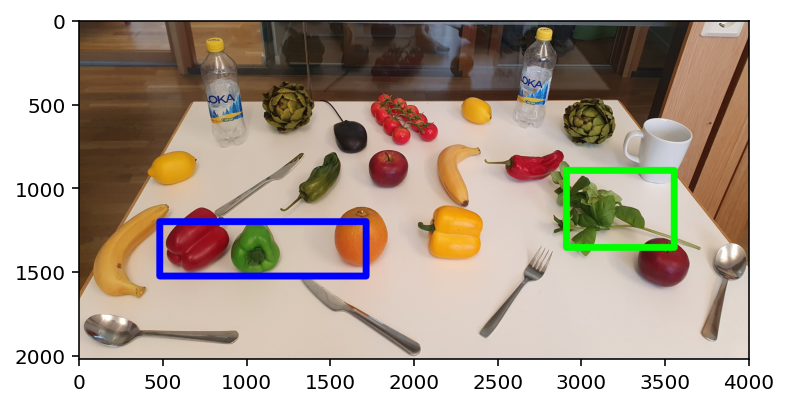

Is the green vegetable to the left of the cup from your viewpoint?
Yes, No?yes


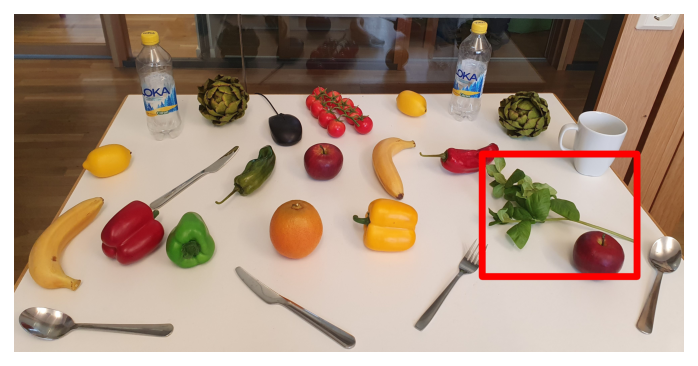

In [49]:

global_probas, global_bboxes_scaled = obj_det(True, im)
general_output_dict = returnout_dict(im, global_probas, global_bboxes_scaled)
region_boxes = []
asked_questions = []
colors = [(0,255,0),(255,0,0),(0,0,255),(0,0,0),(255,255,255)]
while True:
    region_boxes = []
    expr = input('Decribe the object:')
    (resulting_bb, ind, dist, num) = resultsGradCAM_final(img_path,img_name,tar_path,expr)
    doc = nlp(expr)
    nouns = [chunk.text for chunk in doc.noun_chunks]
    if not nouns:
        nouns = ['object']
    lookitems = inexp(nouns)
    
    

    region_check_items = []
    countval = 0
    for j in range(len(region_boxes)):
        for i in range(len(global_bboxes_scaled)):
            x0_i = int(global_bboxes_scaled[i][0])
            y0_i = int(global_bboxes_scaled[i][1])
            x1_i = int(global_bboxes_scaled[i][2])
            y1_i = int(global_bboxes_scaled[i][3])
            if intersects(region_boxes[j],[x0_i,x1_i,y0_i,y1_i]) > 0 and CLASSES1[global_probas[i].argmax()] in lookitems:
                region_check_items.append((region_names[j],countval))
                break
        countval += 1
        

    if len(region_check_items) == 1:
        last_call(TAR_DIR+region_check_items[0][0], expr, nouns, region_check_items[0][1], lookitems, copy.deepcopy(general_output_dict))
        break
    else:
        imm = plt.imread(TAR_DIR+ img_name)
        
        output_dict = copy.deepcopy(general_output_dict)

        candidate_centers= []
        it = booltardec(nouns,lookitems, output_dict)
        appended = []
        obj_call_name = 'object'
        col = 0
        if len(region_check_items) > 1:
            if it:
                obj_call_name = it
                res_img_questions = cv2.imread(img_path)
                for item in region_check_items:
                    ind_ob = findclosestnotAppendedObject(resulting_bb[item[1]], output_dict, it, appended)
                    if ind_ob != -1:
                        appended.append(ind_ob)
                        pos = output_dict['detection_boxes'][ind_ob]
                        x0,x1,y0,y1 = pos[1]*X_im, pos[3]*X_im, pos[0]*Y_im, pos[2]*Y_im
                        candidate_centers.append([(x0+x1)/2,(y0+y1)/2])
                        res_img_questions = cv2.rectangle(res_img_questions,(int(x0),int(y0)),(int(x1),int(y1)),colors[col],40)
                        col += 1
                cv2.imwrite(TAR_DIR+"question_regions.jpg", res_img_questions)
                imm_q = plt.imread(TAR_DIR+"question_regions.jpg")
                plt.imshow(imm_q)
                plt.show()
            else:
                obj_call_name = 'object'
                res_img_questions = cv2.imread(img_path)
                for item in region_check_items:
                    x0,x1,y0,y1 = resulting_bb[item[1]]
                    candidate_centers.append([(x0+x1)/2,(y0+y1)/2])
                    X0_obj = x0/X_im
                    Y0_obj = y0/Y_im
                    X1_obj = x1/X_im
                    Y1_obj = y1/Y_im
                    output_dict['detection_boxes'][output_dict['num_detections']] = [Y0_obj,X0_obj,Y1_obj,X1_obj]
                    output_dict['detection_classes'][output_dict['num_detections']] = 91
                    output_dict['detection_scores'][output_dict['num_detections']] = 1.0
                    output_dict['num_detections'] += 1
                    res_img_questions = cv2.rectangle(res_img_questions,(int(x0),int(y0)),(int(x1),int(y1)),colors[col],40)
                    col += 1
                cv2.imwrite(TAR_DIR+"question_regions.jpg", res_img_questions)
                imm_q = plt.imread(TAR_DIR+"question_regions.jpg")
                plt.imshow(imm_q)
                plt.show()
        else:
            if it:
                obj_call_name = it
                res_img_questions = cv2.imread(img_path)
                for item in resulting_bb:
                    ind_ob = findclosestnotAppendedObject(item, output_dict, it, appended)
                    if ind_ob != -1:
                        appended.append(ind_ob)
                        pos = output_dict['detection_boxes'][ind_ob]
                        x0,x1,y0,y1 = pos[1]*X_im, pos[3]*X_im, pos[0]*Y_im, pos[2]*Y_im
                        candidate_centers.append([(x0+x1)/2,(y0+y1)/2])
                        res_img_questions = cv2.rectangle(res_img_questions,(int(x0),int(y0)),(int(x1),int(y1)),colors[col],40)
                        col += 1
                cv2.imwrite(TAR_DIR+"question_regions.jpg", res_img_questions)
                imm_q = plt.imread(TAR_DIR+"question_regions.jpg")
                plt.imshow(imm_q)
                plt.show()
            else:
                obj_call_name = 'object'
                res_img_questions = cv2.imread(img_path)
                for item in resulting_bb:
                    x0,x1,y0,y1 = item
                    candidate_centers.append([(x0+x1)/2,(y0+y1)/2])
                    X0_obj = x0/X_im
                    Y0_obj = y0/Y_im
                    X1_obj = x1/X_im
                    Y1_obj = y1/Y_im
                    output_dict['detection_boxes'][output_dict['num_detections']] = [Y0_obj,X0_obj,Y1_obj,X1_obj]
                    output_dict['detection_classes'][output_dict['num_detections']] = 91
                    output_dict['detection_scores'][output_dict['num_detections']] = 1.0
                    output_dict['num_detections'] += 1
                    res_img_questions = cv2.rectangle(res_img_questions,(int(x0),int(y0)),(int(x1),int(y1)),colors[col],40)
                    col += 1
                cv2.imwrite(TAR_DIR+"question_regions.jpg", res_img_questions)
                imm_q = plt.imread(TAR_DIR+"question_regions.jpg")
                plt.imshow(imm_q)
                plt.show()
        flag = False
        obj_ref_name = ''
        if nouns and len(nouns[0]) > 4 and nouns[0].lower()[:4] == "the ":
            obj_ref_name = nouns[0].lower()[4:]
        elif nouns:
            obj_ref_name = nouns[0].lower()
        for i in range(len(candidate_centers)):
                partial_exp = extract_rel(obj_ref_name, candidate_centers[i][0], candidate_centers[i][1],obj_call_name,output_dict)
                exp = "Is the " + obj_ref_name + partial_exp + "?"
                if partial_exp in asked_questions:
                    continue
                else:
                    print(exp)
                    asked_questions.append(partial_exp)
                    value = input("Yes, No?")
                    if value.lower() == "yes":
                        flag = True
                        break
        if flag:
            if appended:
                last_call(TAR_DIR+"cropped"+str(i)+".jpg", expr, nouns, i, lookitems, copy.deepcopy(output_dict), appended)
            else:
                last_call(TAR_DIR+"cropped"+str(i)+".jpg", expr, nouns, i, lookitems, copy.deepcopy(output_dict))
            break
